# Introduction

Here, we will demonstrate the use of neural networks on the Lab 2 dataset that we have been playing around with.

For the fun of it, we will here use [plot.ly](https://plot.ly/) to make interactive plots. Note that the matplotlib and seaborn based plotting from the previous lecture will mostly work with some minor modifications. This is mostly just to expose you to different options in plotting.

In [1]:
import collections

import numpy as np
import pandas as pd
import plotly.graph_objects as go

import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from pymatgen.core import Composition

rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

%matplotlib inline
%config InlineBackend.figure_format ='retina'


from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [2]:
# by default pandas will recognize NaN (sodium nitride) as nan (not a number)
# to turn off this behavior, we use na_filter=False
data = pd.read_csv("../../labs/lab2/data.csv", index_col=0, na_filter=False)

# Let's create a column of Composition objects using pymatgen.
data["composition"] = [Composition(f) for f in data["formula"]]

Here, we load the elemental data. Unlike lab2, we are simply going to disregard all elemental features that contain NaN. While imputing the mean value is a commonly used data science technique, it really does not work well for materials science problems. We will also use a smaller set of properties.

In [3]:
el_data = pd.read_csv("../../labs/lab2/element_properties.csv", index_col=0)
el_data = el_data[['AtomicRadius', 'AtomicWeight', 'Column', 'Electronegativity', 'Row']]

As before, we will compute the mean, min, and max for every elemental feature. For mean, we are weighting it by composition. As before, we drop all data points that contain NaN.

In [4]:
props = collections.defaultdict(list)

for comp in data["composition"]:
    for c in el_data.columns:
        vals = [el_data[c][el.symbol] * amt for el, amt in comp.items()]
        props["%sMean" % c].append(sum(vals)/ comp.num_atoms)
        props["%sMin" % c].append(min(vals))
        props["%sMax" % c].append(max(vals))
data = data.assign(**props)
data = data.dropna()
print(data.shape)

(124342, 21)


We are left with around 106k data points, Still more than enough for our purposes. Let's create our features and targets.

In [5]:
features = [c for c in data.columns if c.endswith("Mean") or c.endswith("Min") or c.endswith("Max")]
x = data[features]
y_class = [0 if bg < 1e-4 else 1 for bg in data["band_gap"]]
y_reg = data["band_gap"]

Before we proceed further, let us write up some reusable methods to standardize the analysis of different ML models. Copy and pasting code is fine for earlier demos to reiterate the API of scikit-learn, but it is very bad programming practice. By this stage of the course, we want to do things better.

In [6]:
def plot_grid_search_results(gs, plot_type='bar', ylim=None):
    """
    Plots the results of GridSearchCV.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    results = results.melt(id_vars=[x], value_vars=['mean_train_score', 'mean_test_score'],
        var_name="type", value_name='score')
    fig, ax = plt.subplots(figsize=(16, 8))
    if plot_type == "bar":
        ax = sns.barplot(x=x, y="score", hue='type', data=results)
    else:
        ax = sns.scatterplot(x=x, y="score", hue='type', data=results)
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    return fig
    

def plotly_grid_search_results(gs, plot_type='bar', ylim=None):
    """
    Plots the results of GridSearchCV.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    results = pd.DataFrame(gs.cv_results_)
    if plot_type == "bar":
        xval = ["(%s)" % l if not isinstance(l, tuple) else str(l) for l in results[x]]
        fig = go.Figure(data=[
            go.Bar(name='Train', x=xval, y=results['mean_train_score']),
            go.Bar(name='Test', x=xval, y=results['mean_test_score'])
        ])
        fig.update_layout(barmode='group')
    else:
        fig = go.Figure(data=[
            go.Scatter(name='Train', x=results[x], y=results['mean_train_score']),
            go.Scatter(name='Test', x=results[x], y=results['mean_test_score'])
        ])
    fig.update_xaxes(title_text=x)
    fig.update_yaxes(title_text='Score')
    return fig
    
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Neural Networks

We will now use scikit-learn's implementation of neural networks (multi-layer perceptron, or MLP) to repeat the classification and regression tasks from Lab 2.

TypeError: '<' not supported between instances of 'tuple' and 'int'

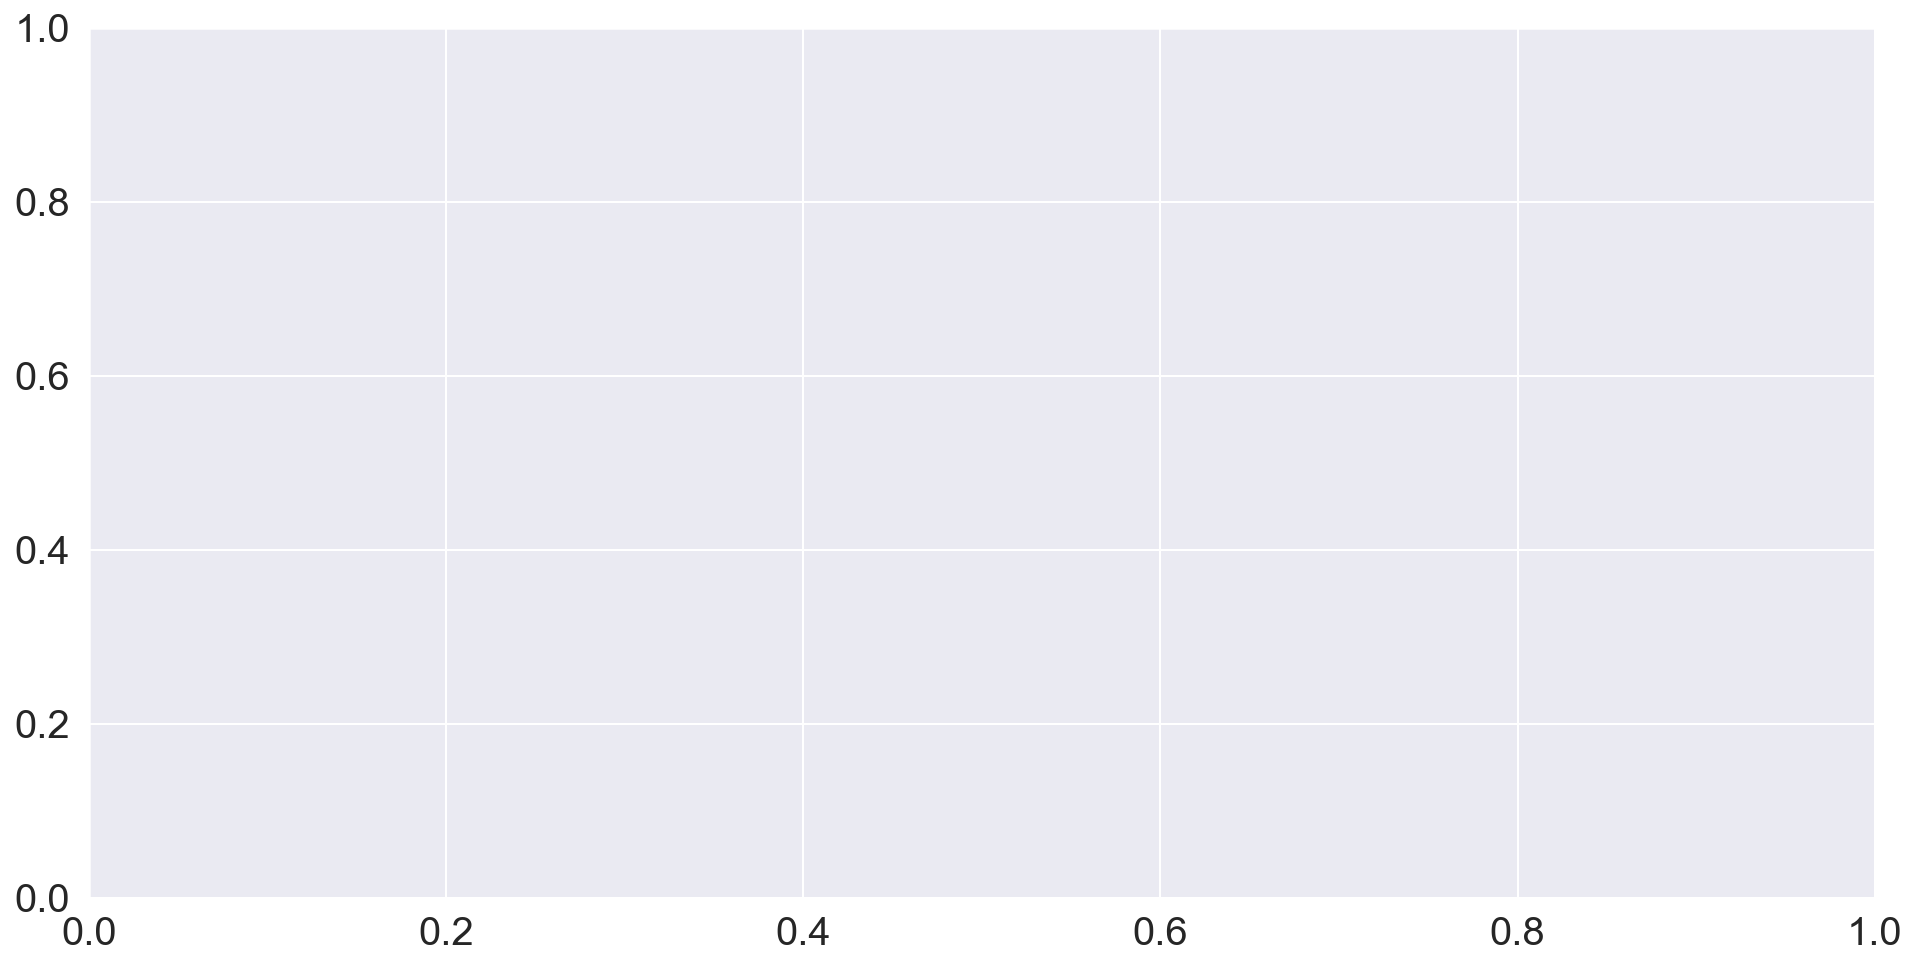

In [7]:
nn = MLPClassifier(alpha=1e-4, random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"hidden_layer_sizes": [(3), (5), (7), (5, 3), (7, 5), (7, 5, 3)]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs).show()
fig = plotly_grid_search_results(gs)
fig.update_yaxes(title_text='accuracy')
fig.show()

Interestingly, only a single hidden layer MLP with 5 parameters seem to have achieved more or less converged performance, and more layers or neurons do not seem to be necessary. It should be noted that this is a relatively simple task, which may explain why deeper MLPs are not needed.

Next, we will choose a reasonable MLP layer configuration (5, 3) and look at the effect of the alpha parameter.

In [ ]:
nn = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"alpha": np.logspace(-6, -1, 6)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs, plot_type='scatter').show()
plt.xscale('log')
fig = plotly_grid_search_results(gs, plot_type='scatter')
fig.update_yaxes(title_text='accuracy')
fig.update_xaxes(type="log")

We see that the results do not really vary that much with alpha in this case.

Now for the regression task.

In [ ]:
nn = MLPRegressor(alpha=1e-4, random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"hidden_layer_sizes": [(3), (5), (7), (5, 3), (7, 5), (7, 5, 3)]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs).show()
fig = plotly_grid_search_results(gs)
fig.update_yaxes(title_text='-MSE')
fig.show()

We see that the best we can do again, is around 1.67 eV or so, which is approximately the same result we have obtained with the trees without overfitting (if we allow overfitting, the trees can achieve slightly better MSEs).

To make it more challenging for the MLP, we will now severely reduce our dataset to just the mean values, without Max or Min. Let's see what kind of MLP configuration is needed to achieve good results in this case.

In [ ]:
x_small = data[[c for c in data.columns if c.endswith("Mean")]]
nn = MLPRegressor(alpha=1e-4, random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"hidden_layer_sizes": [(3), (5), (7), (5, 3), (7, 5), (9, 7), (11, 9), (13, 11), (7, 5, 3)]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x_small, y_reg)
plot_grid_search_results(gs).show()
fig = plotly_grid_search_results(gs)
fig.update_yaxes(title_text='-MSE')
fig.show()

# Tensorflow example

Below is an example implementation of the regressor using Tensorflow 2.0 with the functional API. We will just do a simple train test split given that we cannot use scikit-learn's cross validation features.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_small, y_reg, test_size=0.9, random_state=42)

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Note that the choices are explicitly chosen to be equivalent to the scikit-learn MLP defaults,
# which are the use of relu as the activation function (in TF, this must be explicitly specified),
# the Adam optimizer is used with learning rate of 0.01 and the loss is MSE.

x_in = Input(shape=(x_small.shape[1],))
x_h1 = Dense(13, activation="relu")(x_in)
x_h2 = Dense(11, activation="relu")(x_h1)
x_out = Dense(1)(x_h2)
model = Model(inputs=x_in, outputs=x_out)
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')
model.fit(np.array(x_train), np.array(y_train), epochs=200, batch_size=200, verbose=0)

y_pred_train = model.predict(np.array(x_train))
y_pred_test = model.predict(np.array(x_test))
mse_train = np.sum((y_pred_train.ravel() - y_train)**2) / len(y_train)
mse_test = np.sum((y_pred_test.ravel() - y_test)**2) / len(y_test)
print("Training MSE = %.3f; Test MSE = %.3f" % (mse_train, mse_test))